In [104]:
import pandas as pd
import numpy as np
from IPython.display import display
import csv
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import os

if not os.path.isdir("/dev/shm/shearing"):
    os.makedirs("/dev/shm/shearing")

In [8]:
%%time
shear_results = "../data/references/rep82/shear_results.b6"
shear_results_fixed = "/dev/shm/shearing/shear_results.fixed.b6"
!sed 's/_/./1' {shear_results} > {shear_results_fixed}

CPU times: user 1min 6s, sys: 12.4 s, total: 1min 18s
Wall time: 10min 42s


In [12]:
%%time
otu_table = "/dev/shm/shearing/shear_results.otu.txt"
taxa_table = "/dev/shm/shearing/shear_results.taxatable.txt"
!embalmulate {shear_results_fixed} {otu_table}

Parsed 406474006 reads [12976 samples, 0 taxa, 12958 refs]. Collating...
CPU times: user 1min 15s, sys: 14.3 s, total: 1min 30s
Wall time: 15min 26s


In [119]:
with open(otu_table) as inf:
    csv_inf = csv.reader(inf, delimiter="\t")
    columns = next(csv_inf)
    columns = dict(zip(columns[1:], range(len(columns))))
    indptr = [0]
    indices = np.array([], dtype=int)
    data = np.array([], dtype=int)
    names = []
    for ix, row in enumerate(csv_inf):
        if ix % 1000 == 0:
            print(ix)
        names.append(row[0])
        np_row = np.array(row[1:], dtype=int)
        temp_indx = [np_row > 0]
        data = np.concatenate((data, np_row[temp_indx]))
        indices = np.concatenate((indices, np.where(temp_indx)[1]))
        indptr.append(indices.shape[0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [120]:
from scipy.sparse import csr_matrix

# samples by taxonomy
csr = csr_matrix((data, indices, indptr), dtype=int).T

In [121]:
# Load up the accession2taxonomy
with open("../data/references/rep82/rep82.tax") as inf:
    csv_inf = csv.reader(inf, delimiter='\t')
    name2taxonomy = dict(csv_inf)

In [122]:
cols_tax = [name2taxonomy[name] for name in names]
rows_tax = [name2taxonomy[_.replace(".", "_", 1)] for _ in sorted(columns, key=columns.get)]

In [123]:
def index_lca(str1, str2):
    for i, (s1, s2) in enumerate(zip(str1.split(';'), str2.split(';'))):
        if s1 != s2:
            return i
    return 8

dat = np.zeros((len(rows_tax), 9), dtype=int)
for i, row_name in enumerate(rows_tax):
    row = csr.getrow(i)
    for j, indx in enumerate(row.indices):
        dat[i, index_lca(rows_tax[i], cols_tax[indx])] += row.data[j]

In [124]:
dat[:, 0].sum()

193728

In [125]:
import pandas as pd
df = pd.DataFrame(dat, index=rows_tax)

In [126]:
df['sum'] = dat.sum(axis=1)

In [127]:
df.head()

,0,1,2,3,4,5,6,7,8,sum
"k__Viruses;p__ssRNA viruses;c__ssRNA positive-strand viruses, no DNA stage;o__;f__;g__;s__Phytophthora infestans RNA virus 1;t__",0,0,0,0,0,0,0,0,120,120
k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Planctomycetales;f__Gemmataceae;g__Gemmata;s__Gemmata obscuriglobus;t__Gemmata obscuriglobus UQM 2246,8,97,0,0,0,0,0,0,181382,181487
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. FJAT-14578;t__,1,3,0,0,16,20,139,0,111122,111301
"k__Viruses;p__dsDNA viruses, no RNA stage;c__Caudovirales;o__;f__Podoviridae;g__;s__Bacillus phage Stitch;t__",0,1,0,0,0,0,16,0,469,486
"k__Viruses;p__ssRNA viruses;c__ssRNA positive-strand viruses, no DNA stage;o__;f__Virgaviridae;g__Tobamovirus;s__Hibiscus latent Singapore virus;t__",0,0,0,0,0,0,0,0,129,129


In [128]:
df.drop(0, axis=1, inplace=True)

In [129]:
df.head()

,1,2,3,4,5,6,7,8,sum
"k__Viruses;p__ssRNA viruses;c__ssRNA positive-strand viruses, no DNA stage;o__;f__;g__;s__Phytophthora infestans RNA virus 1;t__",0,0,0,0,0,0,0,120,120
k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Planctomycetales;f__Gemmataceae;g__Gemmata;s__Gemmata obscuriglobus;t__Gemmata obscuriglobus UQM 2246,97,0,0,0,0,0,0,181382,181487
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus;s__Bacillus sp. FJAT-14578;t__,3,0,0,16,20,139,0,111122,111301
"k__Viruses;p__dsDNA viruses, no RNA stage;c__Caudovirales;o__;f__Podoviridae;g__;s__Bacillus phage Stitch;t__",1,0,0,0,0,16,0,469,486
"k__Viruses;p__ssRNA viruses;c__ssRNA positive-strand viruses, no DNA stage;o__;f__Virgaviridae;g__Tobamovirus;s__Hibiscus latent Singapore virus;t__",0,0,0,0,0,0,0,129,129


In [130]:
df.to_csv("../data/references/rep82/sheared_bayes.txt", header=False, sep="\t")

In [131]:
uniqueness_rate_per_level = np.zeros(8, dtype=float)
for i in range(0, 8):
    # Take the sum of those columns
    num_hits =  df.iloc[:, i].sum()
    # Total number of possible hits
    total_hits = df['sum'].sum()
    # Uniqueness Rate
    uniqueness_rate_per_level[i] = num_hits/total_hits
levels = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'strain']
list(zip(levels, uniqueness_rate_per_level))
print(uniqueness_rate_per_level.sum())

0.999523393877


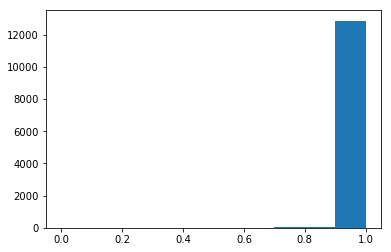

In [132]:
# Distribution of uniqueness
plt.hist(df.iloc[:, 1:8].sum(axis=1)/df['sum'])
plt.show()

In [133]:
low_uniqueness = df[df.iloc[:, 1:8].sum(axis=1)/df['sum'] < 1.1]
print(low_uniqueness)
kingdom_freq_low = Counter([_.split(';')[0] for _ in low_uniqueness.index])
print(kingdom_freq_low)

                                                      1   2    3    4      5  \
k__Viruses;p__ssRNA viruses;c__ssRNA positive-s...    0   0    0    0      0   
k__Bacteria;p__Planctomycetes;c__Planctomycetia...   97   0    0    0      0   
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacilla...    3   0    0   16     20   
k__Viruses;p__dsDNA viruses, no RNA stage;c__Ca...    1   0    0    0      0   
k__Viruses;p__ssRNA viruses;c__ssRNA positive-s...    0   0    0    0      0   
k__Viruses;p__dsRNA viruses;c__Totiviridae;o__;...    0   0    0    0      0   
k__Viruses;p__dsRNA viruses;c__unclassified dsR...    0   0    0    0      0   
k__Viruses;p__unclassified viruses;c__Torulaspo...    0   0    0    0      0   
k__Viruses;p__ssRNA viruses;c__ssRNA positive-s...    0   0    0    0      0   
k__Bacteria;p__Proteobacteria;c__Epsilonproteob...   13   0    0    0     10   
k__Bacteria;p__Proteobacteria;c__Gammaproteobac...    0   0    4    0      0   
k__Bacteria;p__Firmicutes;c__Clostridia;